# Background

This Jupyter notebook is following the tutorial provided on the Visual Studio website: https://code.visualstudio.com/docs/datascience/data-science-tutorial

In [1]:
# Import neccessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data setup
## Import data
This tutorial uses the Titanic dataset available on OpenML.org, which is obtained from Vanderbilt University's Department of Biostatistics at https://hbiostat.org/data. The Titanic data provides information about the survival of passengers on the Titanic and characteristics about the passengers such as age and ticket class. Using this data, the tutorial will establish a model for predicting whether a given passenger would have survived the sinking of the Titanic. This section shows how to load and manipulate data in your Jupyter notebook. This is saved within the folder as data.csv.

In [2]:
# Load in data from CSV file
data = pd.read_csv('data.csv')

## Clean data 
Before the data can be graphed, I need to make sure that there aren't any issues with it. Looking at the Titanic csv file, a question mark ("?") was used to identify cells where data wasn't available. While Pandas can read this value into a DataFrame, the result for a column like age is that its data type will be set to object instead of a numeric data type, which is problematic for graphing. This problem can be corrected by replacing the question mark with a missing value that pandas is able to understand. 

In [3]:
# Replace unknown data with NaN values
data.replace('?', np.nan, inplace= True)

# Conversion to desired data type (float instead of string)
data = data.astype({"age": np.float64, "fare": np.float64})

# Examine basic relationships
## Plot predictors against survival
To look at the relationship between predictors, we will plot it, split by age/survival/sex.

<AxesSubplot:xlabel='survived', ylabel='fare'>

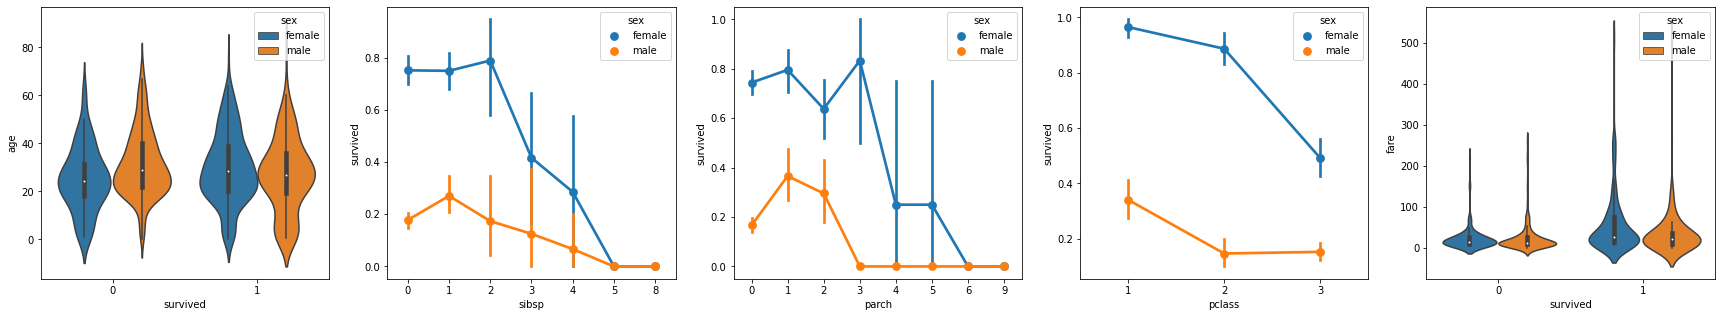

In [4]:
# Generate figure
fig, axs = plt.subplots(ncols=5, figsize=(30,5))

sns.violinplot(x="survived", y="age", hue="sex", data=data, ax=axs[0])
sns.pointplot(x="sibsp", y="survived", hue="sex", data=data, ax=axs[1])
sns.pointplot(x="parch", y="survived", hue="sex", data=data, ax=axs[2])
sns.pointplot(x="pclass", y="survived", hue="sex", data=data, ax=axs[3])
sns.violinplot(x="survived", y="fare", hue="sex", data=data, ax=axs[4])

## Correlate variables
Look at correlations between all input variables and survival

In [5]:
# For analysis, convert string to value (i.e. male to 1, female to 0)
data.replace({'male': 1, 'female': 0}, inplace=True)

# Look at correlations between all input variables and survival
data.corr().abs()[["survived"]]


,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055513
sibsp,0.027825
parch,0.082660
fare,0.244265


## Derive a new variable
Looking at the correlation results, some variables like gender have a fairly high correlation to survival, while others like relatives (sibsp = siblings or spouse, parch = parents or children) seem to have little correlation.

Let's hypothesize that sibsp and parch are related in how they affect survivability, and group them into a new column called "relatives" to see whether the combination of them has a higher correlation to survivability. To do this, you will check if for a given passenger, the number of sibsp and parch is greater than 0 and, if so, you can then say that they had a relative on board.

In [6]:
# Create a new variables called relative (if they had a sibling | parent/child onboard too)
data['relatives'] = data.apply (lambda row: int((row['sibsp'] + row['parch']) > 0), axis=1)

# Run correlation analysis
data.corr().abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055513
sibsp,0.027825
parch,0.082660
fare,0.244265
relatives,0.201719


# Prepare data for model training/testing
## Clean data for training a model
When looked at from the standpoint of whether a person had relatives, versus how many relatives, there is a higher correlation with survival. With this information in hand, I can now drop from the dataset the low value sibsp and parch columns, as well as any rows that had NaN values, to end up with a dataset that can be used for training a model.

In [7]:
# Remove entries with NaN from imported data and make a new table with the relevant columns
data = data[['sex', 'pclass','age','relatives','fare','survived']].dropna()

## Split data
With the dataset ready, I can now begin creating a model. For this section, I will use the scikit-learn library (as it offers some useful helper functions) to do pre-processing of the dataset, train a classification model to determine survivability on the Titanic, and then use that model with test data to determine its accuracy.

A common first step to training a model is to divide up the dataset into training and validation data. This allows you to use a portion of the data to train the model and a portion of the data to test the model. If you used all your data to train the model, you wouldn't have a way to estimate how well it would actually perform against data the model hasn't yet seen. A benefit of the scikit-learn library is that it provides a method specifically for splitting a dataset into training and test data.

In [8]:
# Import split data tool from sk-learn library
from sklearn.model_selection import train_test_split

# Split datatable into a train/test set
x_train, x_test, y_train, y_test = train_test_split(data[['sex','pclass','age','relatives','fare']], data.survived, test_size=0.2, random_state=0)

## Normalise and organise data

Next, I've normalized the inputs such that all features are treated equally. For example, within the dataset the values for age range from ~0-100, while gender is binary. By normalizing all the variables, I can ensure that the ranges of values are all the same.

In [9]:
# Import scaling tool from sk-learn library
from sklearn.preprocessing import StandardScaler

# Relabel StandardScale class as sc for future calls
sc = StandardScaler()

# The fit method is calculating the mean and variance of each of the features present in our data. 
# The transform method is transforming all the features using the respective mean and variance.
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

# Model 1: Naïve Bayes algorithm
## Define & train model
There are many different machine learning algorithms that can be used to model. The scikit-learn library also provides support for many of them and a chart to help select the one that's right for your scenario. For now, use the Naïve Bayes algorithm, a common algorithm for classification problems.

In [11]:
# Import the (Gaussian) Naive Bayes algorithm from the sk-learn library
from sklearn.naive_bayes import GaussianNB

# Define the model as Gaussian Naive Bayes
model = GaussianNB();

# Fit the model to the training data
model.fit(X_train, y_train)

GaussianNB()

## Test model
Now I've trained the model, I will now test is against the data set aside previously. 

In [12]:
# Import the metrics class from the sk-learn library
from sklearn import metrics

# Predict data using the X_test data with the model we previously made
predict_test = model.predict(X_test)

# Output the accuracy score
print(metrics.accuracy_score(y_test, predict_test))

0.7464114832535885


## Outcome 
Looking at the result of the test data, we can see that the trained algorithm had a ~75% success rate at estimating survival based on all the inputted predictors (sex, class, age, relatives, fare)



# Model 2: Neural Network 
A neural network is a model that uses weights and activation functions, modeling aspects of human neurons, to determine an outcome based on provided inputs. Unlike the machine learning algorithm used above, neural networks are a form of deep learning wherein you don't need to know an ideal algorithm for your problem set ahead of time. It can be used for many different scenarios and classification is one of them. For this section, I'll use the Keras library with TensorFlow to construct the neural network, and explore how it handles the Titanic dataset.

The first step is to import the required libraries and to create the model. In this case, I'll use a Sequential neural network, which is a layered neural network wherein there are multiple layers that feed into each other in sequence.

In [13]:
# Import libraries from Keras
from keras.models import Sequential
from keras.layers import Dense

# Define the model as Sequential
model = Sequential()

2022-01-15 09:27:32.399867: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Define and train model
After defining the model, the next step is to add the layers of the neural network. For now, let's keep things simple and just use three layers.

The first layer will be set to have a dimension of 5, since I have five inputs: sex, pclass, age, relatives, and fare.
The last layer must output 1, since you want a 1-dimensional output indicating whether a passenger would survive.
The middle layer was kept at 5 for simplicity, although that value could have been different.

The rectified linear unit (relu) activation function is used as a good general activation function for the first two layers, while the sigmoid activation function is required for the final layer as the output you want (of whether a passenger survives or not) needs to be scaled in the range of 0-1 (the probability of a passenger surviving).

In [17]:
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 5)); # Layer 1
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu'));                # Layer 2
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'));             # Layer 3

model.summary() # Summarise the model to check the layers are set correctly

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy']); # Compile model 
model.fit(X_train, y_train, batch_size=32, epochs=50); # Fit model to the previously defined training data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
 dense_3 (Dense)             (None, 5)                 10        
                                                                 
 dense_4 (Dense)             (None, 5)                 30        
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
 dense_6 (Dense)             (None, 5)                 1

## Test Model
Now that the model is built and trained, I can now look at how it works against the test data.

In [18]:
y_pred = np.argmax(model.predict(X_test), axis=-1) # Generate predicted values from model
print(metrics.accuracy_score(y_test, y_pred))      # Determine accuracy of the model 

0.6124401913875598
